<a href="https://www.kaggle.com/code/siddp6/telescope?scriptVersionId=180493100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [ ]:
import torch # PyTorch library for tensor computations
import os # for operating system dependent functionalities
import shutil # for high-level file operations

import torchvision.transforms as T # for modifying the image
import matplotlib.pyplot as plt # for plotting images
import torch.nn as nn # for convolutional neural network
import torch.nn.functional as F # for loss function

from torch.utils.data import Dataset, DataLoader # for creating dataset and loading them to model
from PIL import Image # for viewing the image
from torchvision.utils import make_grid # for making image grid
from tqdm.notebook import tqdm # for progress bar
from torchvision.utils import save_image # to save images
from torchvision.datasets import ImageFolder # for loading datasets from folders


## Data

In [ ]:
# when run from collab

# !unzip -q moon.zip -d /content/moon
# DATA_DIR = "/content/moon"

In [ ]:
# when run from Kaggle 


DATA_DIR = "/kaggle/input/sun-and-moon-images/moon/"

- Neural networks generally perform better with input data that ranges around 0 and has a small, uniform scale. 
- By normalizing the images, the pixel values (originally ranging from 0 to 255) are typically scaled to a range such as -1 to 1 (if using a mean of 0.5 and standard deviation of 0.5). 
- This helps in speeding up the convergence during training because it ensures that the input features (pixel values) are on a similar scale, aiding the optimization algorithms to work more efficiently.


In [ ]:
# Define the size of the images, higher value means higher quality
image_size = 64

"""
The stats tuple (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) represents the means and standard deviations for each
of the three color channels (red, green, blue) used to normalize the images.
"""

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Define the batch size for data loading
batch_size = 128

# Define the transformations to be applied to the images
transformer = T.Compose([
    T.Resize(image_size),               # Resize the image to the specified size
    T.CenterCrop(image_size),           # Crop the center of the image to the specified size
    T.RandomHorizontalFlip(0.5),        # Randomly flip the image horizontally with a probability of 0.5
    T.ToTensor(),                       # Convert the image to a PyTorch tensor
    T.Normalize(*stats)                 # Normalize the tensor using the specified mean and std deviation
])


In [ ]:
# Load the dataset from the  directory and apply transformations
dataset = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),               # Resize the images to the specified size
    T.CenterCrop(image_size),           # Crop the center of the images to the specified size
    T.ToTensor(),                       # Convert the images to PyTorch tensors
    T.Normalize(*stats)                 # Normalize the tensors using the specified mean and std deviation
]))

# DataLoader to handle batching and loading of the dataset
dataset_loader = DataLoader(
    dataset,                 # The dataset to load
    batch_size,              # Number of images in each batch
    shuffle=True,            # Shuffle the data to randomize the order of images
    num_workers=4,           # Number of subprocesses to use for data loading
    pin_memory=True          # If True, the DataLoader will copy tensors into CUDA pinned memory before returning them
)


- The pin_memory option in PyTorch's DataLoader is used to enable faster transfers of data from host (CPU) memory to GPU memory, which can lead to performance improvements during training deep learning models.

## Model Intuition

### Discriminator and Generator

The __discriminator__ will be like a traditional neural network that classifies things. In our case, it will classify the images as real or fake.

The __generator__ will be a neural network that generates fake images, and such types of neural networks use deconvolution layers.

Now, it is clear why we need a generator. Because we want to generate fake images. The __generator__ will be trained on real images, learning the patterns, and will generate fake images based on those patterns.

Okay, but why do we need a __discriminator__? The reason is that we need to tell the __generator__ how good or bad it is at doing the job. We want to generate fake images that should look like real ones. So, the __discriminator__ will determine if the image generated by the __generator__ is real or not. The __generator__ should try to fool the __discriminator__ in such a way that it flags the fake image as real. And wait, if the __discriminator__, which is a neural network that classifies images as real or fake, is saying that an image created by the __generator__ is real, that means it is working.

So, the __discriminator__'s job is to classify the image as real or fake. And the __generator__'s job is to generate images that the __discriminator__ classifies as real.

## Discriminator and Generator

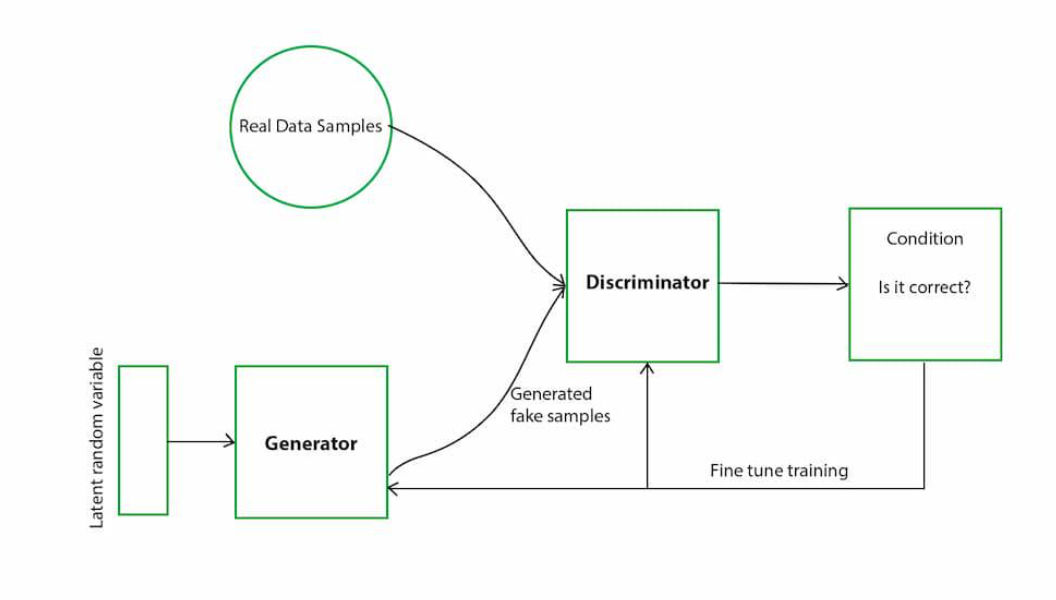

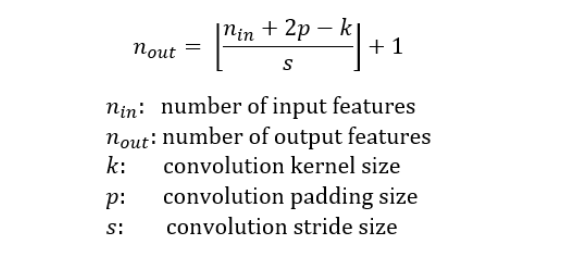

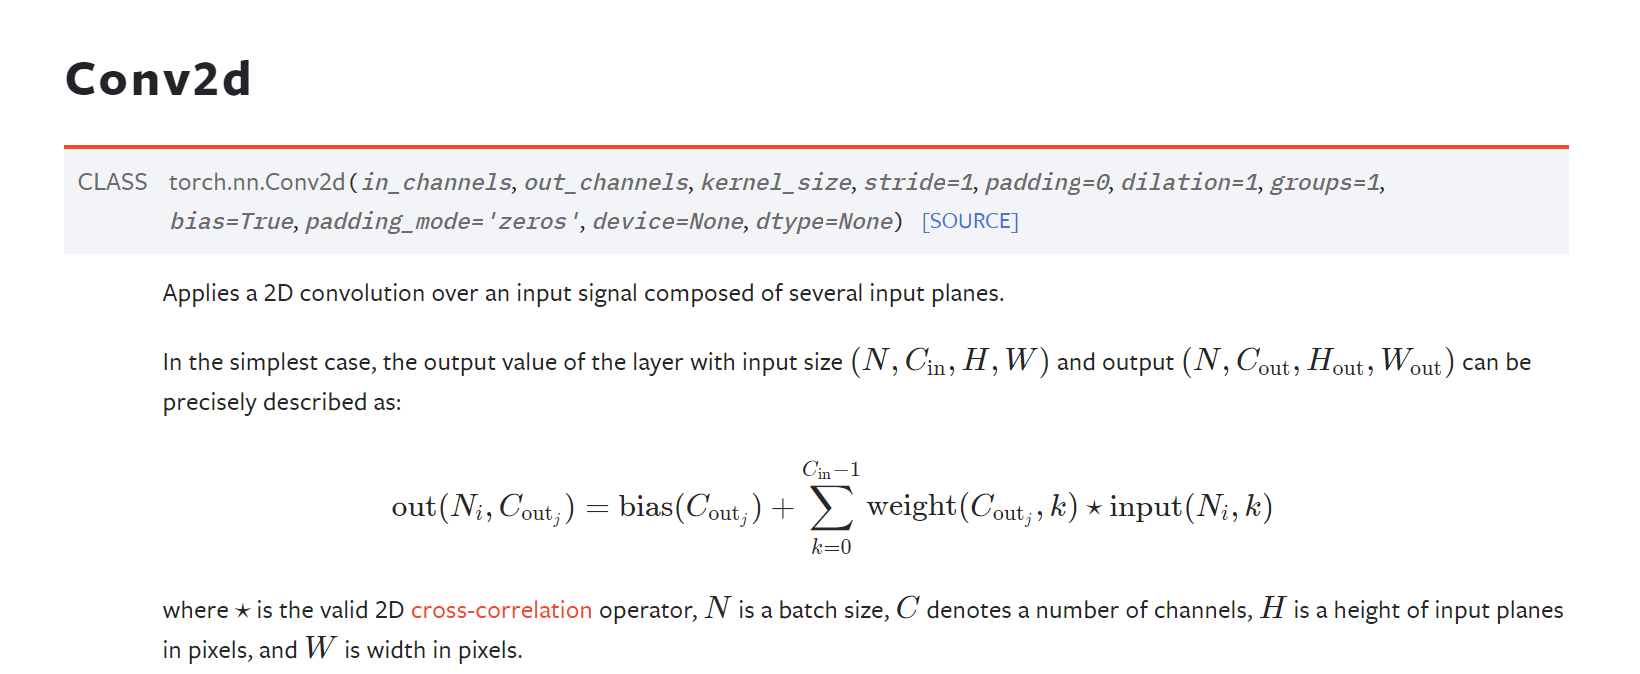

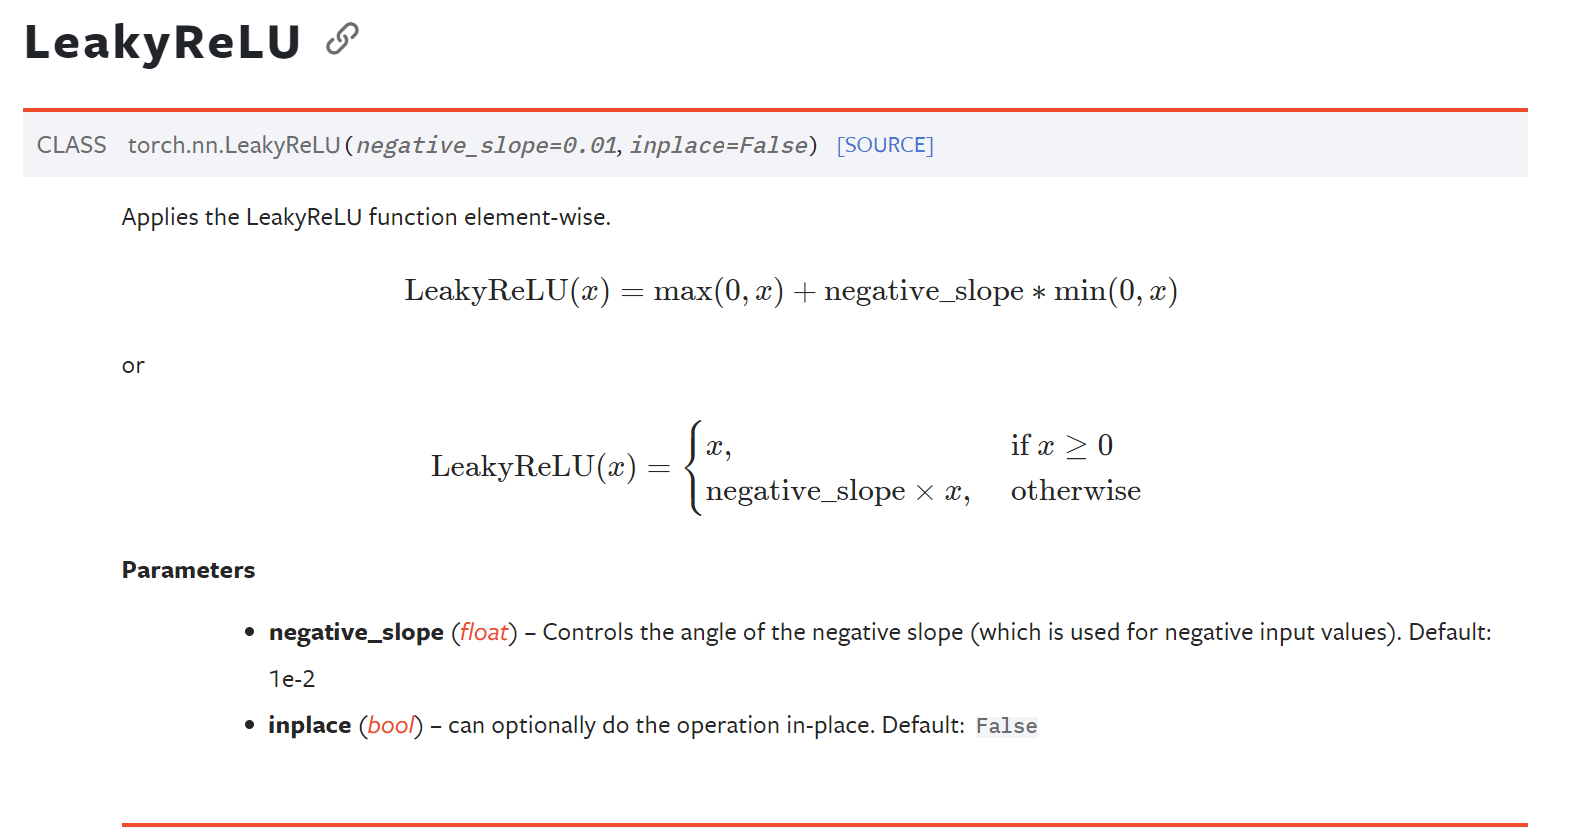

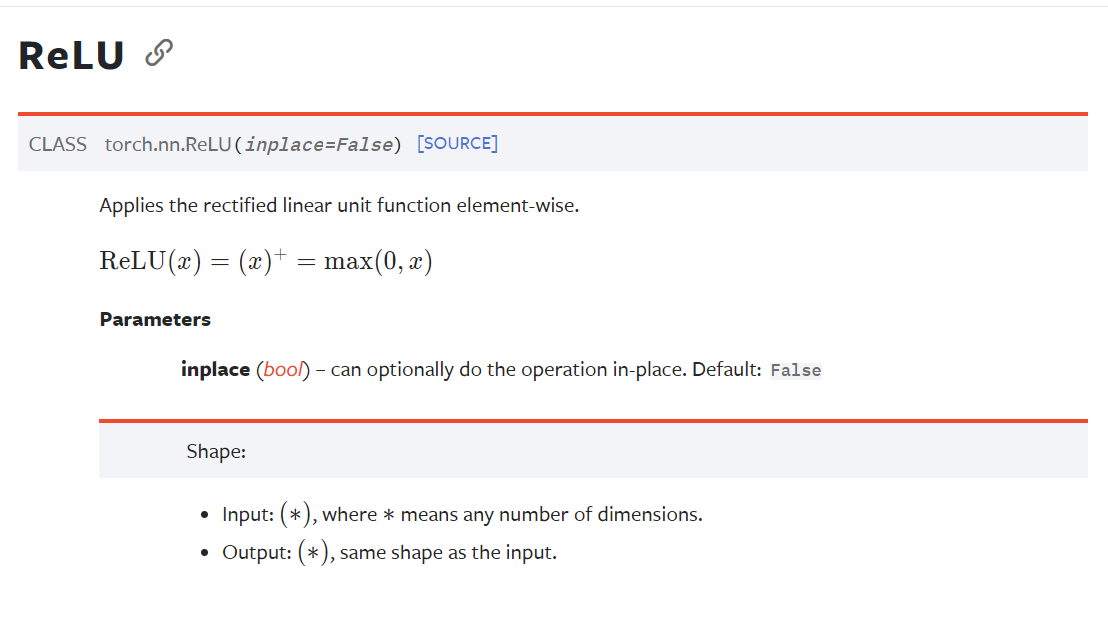

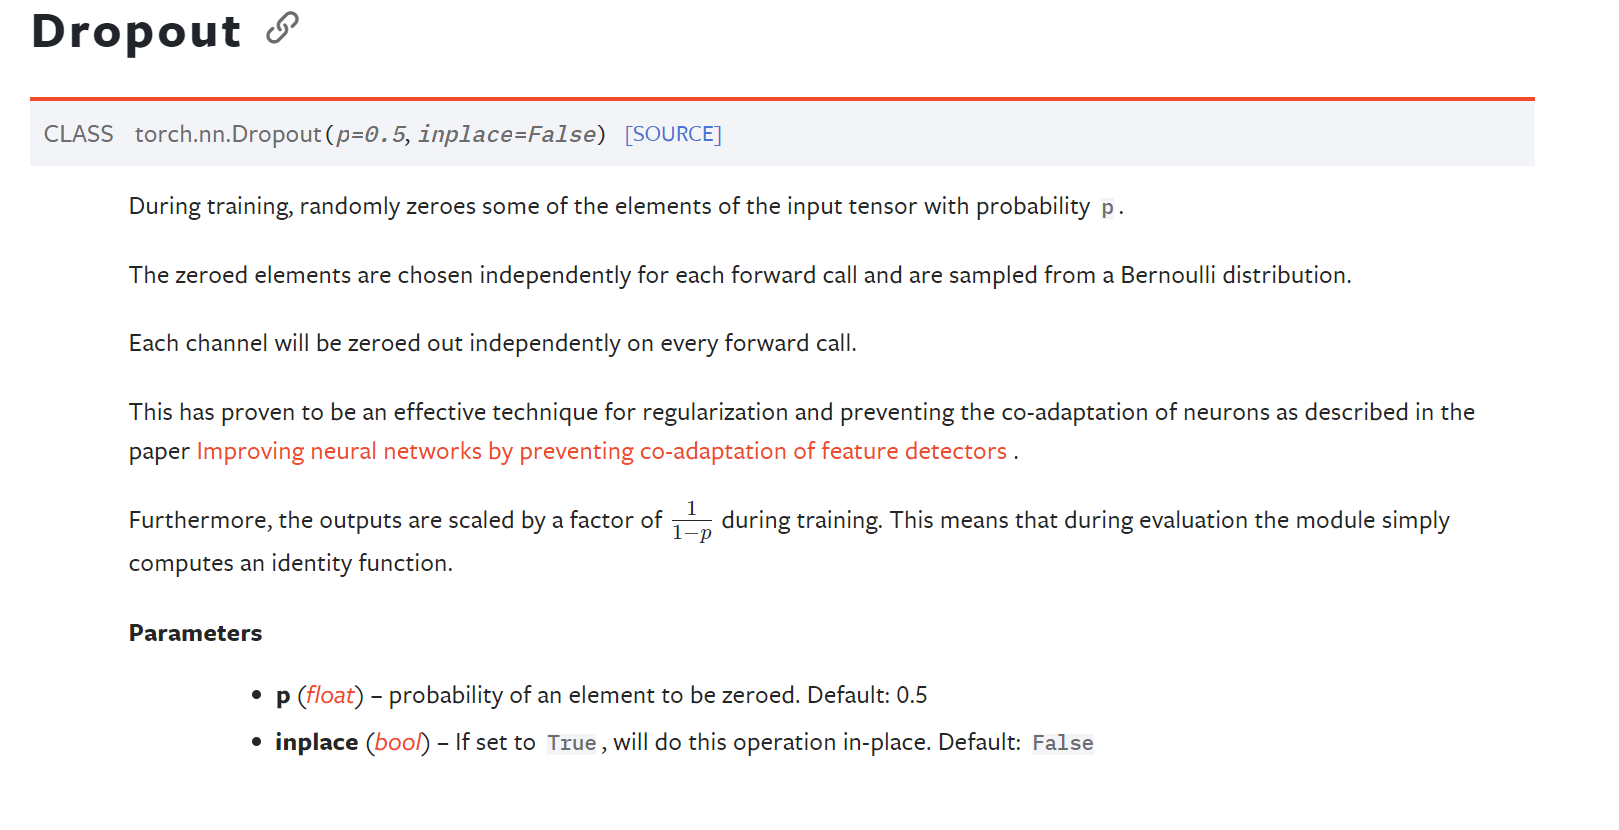

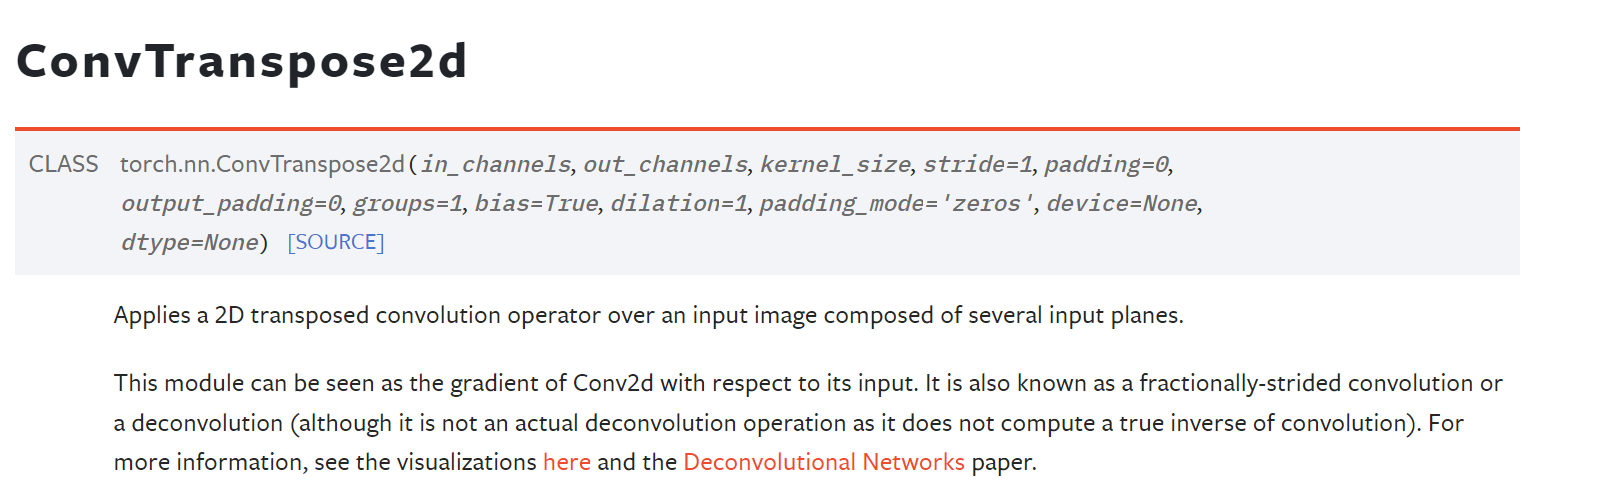

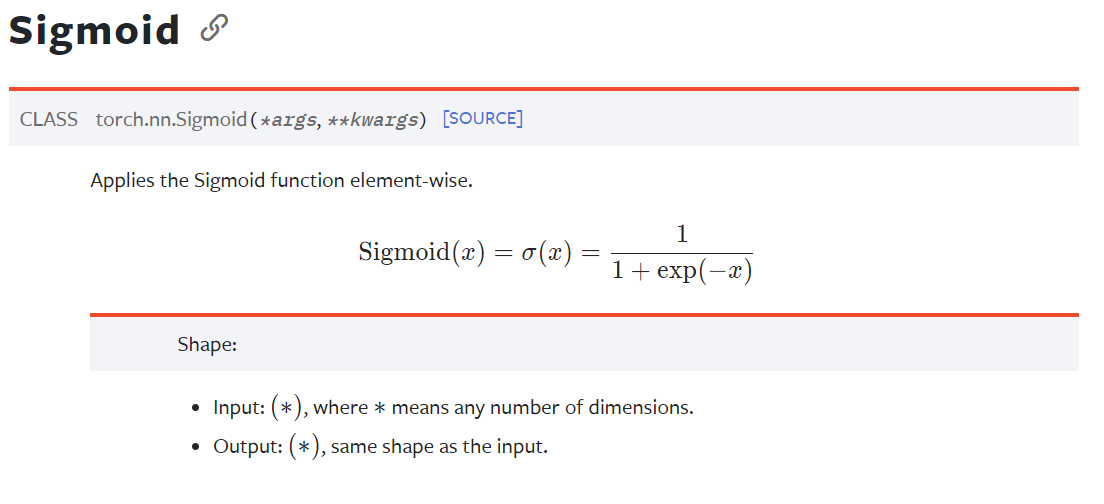

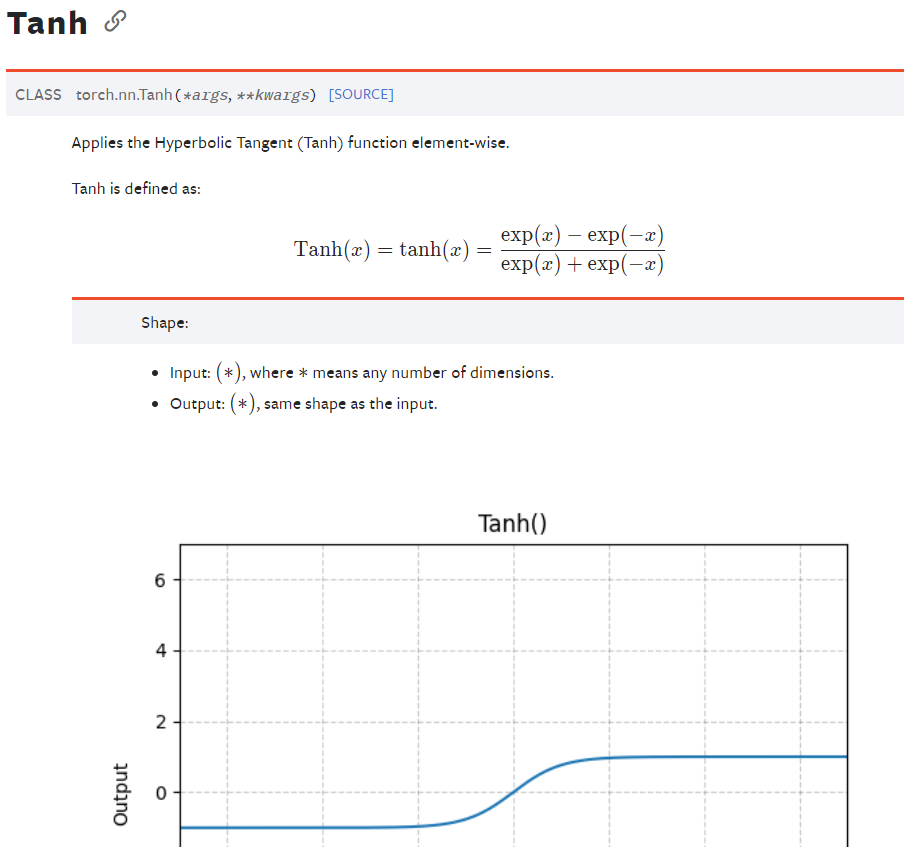

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(inplace=True),
    # out: 1024 x 2 x 2

    nn.Conv2d(1024, 1, kernel_size=2, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 4 x 4

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 8 x 8

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 16 x 16

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 32 x 32

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Set GPU

In [ ]:
def get_device():
    """
    Determines the best available device for computations (CPU or GPU).

    Returns:
        torch.device: The device ('cuda' or 'cpu') where tensors should be allocated.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')  # Return a GPU device if CUDA is available
    else:
        return torch.device('cpu')   # Return CPU if CUDA is not available

def to_device(data, device):
    """
    Recursively moves tensors to the specified device.

    Args:
        data (tensor, list, tuple): Data to be moved to the device.
        device (torch.device): The device to move data to.

    Returns:
        Tensor or list of tensors moved to the specified device.
    """
    if isinstance(data, (list, tuple)):
        # Recursively move each item to the device if data is a list or tuple
        return [to_device(x, device) for x in data]
    else:
        # Move tensor to device asynchronously for performance
        return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """
    A wrapper around DataLoader to automatically move data to a device during iteration.
    """
    def __init__(self, dl, device):
        """
        Initializes the DeviceDataLoader.

        Args:
            dl (DataLoader): The DataLoader whose batches will be moved to the device.
            device (torch.device): The device to move data to.
        """
        self.dl = dl      # The DataLoader to wrap
        self.device = device  # The device to move data to

    def __iter__(self):
        """
        Yield a batch of data after moving it to the specified device.
        """
        for data in self.dl:
            yield to_device(data, self.device)  # Move each batch to device before yielding

    def __len__(self):
        """
        Returns the number of batches available in the DataLoader.
        """
        return len(self.dl)  # Return the length of the underlying DataLoader

In [ ]:
torch.cuda.empty_cache()

device = get_device()

dataset_loader = DeviceDataLoader(dataset_loader, device)
print(f"Train loader device: {next(iter(dataset_loader))[0].device}")

discriminator = to_device(discriminator, device)
print(f"Discriminator device: {next(discriminator.parameters()).device}")

generator = to_device(generator, device)
print(f"Generator device: {next(generator.parameters()).device}")

In [ ]:
def denorm(img_tensors):
    """
    Denormalizes a batch of image tensors by multiplying by the standard deviation and adding the mean.

    Args:
        img_tensors (torch.Tensor): A batch of normalized image tensors.

    Returns:
        torch.Tensor: A batch of denormalized image tensors.
    """
    # Get the mean and std deviation for normalization
    stats_mean = torch.tensor(stats[0]).view(3, 1, 1).to(img_tensors.device)
    stats_std = torch.tensor(stats[1]).view(3, 1, 1).to(img_tensors.device)
    # Denormalize the image tensors
    return img_tensors * stats_std + stats_mean

def show_images(images, nmax=16):
    """
    Displays a grid of images.

    Args:
        images (torch.Tensor): A batch of image tensors.
        nmax (int, optional): Maximum number of images to display. Defaults to 16.
    """
    # Create a plot to display the images
    fig, ax = plt.subplots(figsize=(32, 32))
    # Show a grid of images
    ax.imshow(make_grid(denorm(images)[:nmax].cpu(), nrow=4).permute(1, 2, 0).numpy())
    plt.show()

def show_batch(dl):
    """
    Displays a batch of images from a DataLoader.

    Args:
        dl (DataLoader): A DataLoader object containing the dataset.
    """
    for images, _ in dl:  # the DataLoader returns batches of (images, labels)
        # Display the images in the batch
        show_images(images)
        break

# Show a batch of images from the dataset
show_batch(dataset_loader)


### Training Intuition

__train_discriminator__
 - Pass the real image to this network.
 - Create a label, where the true label will be 1 because all images are real.
 - Use `binary_cross_entropy` to find the loss from the true label and predicted output. We call it `real_loss`, as this is the loss from training on the real image.
 - But we want our __discriminator__ to flag whether the image is true or fake, and in the above step, we have given it only real images. So we use the __generator__ to generate a fake image and use a label of 0 because all images from the __generator__ are fake.
 - Use `binary_cross_entropy` to find the loss again, and we call it `fake_loss`.
 - We add these losses and perform backpropagation.
 
__train_generator__
- Remember, any image is represented as an integer. So as input to the __generator__, we will use some random numbers, which we call latent in technical terms. 
- Once the __generator__ gives us some output, we will send this to the __discriminator__, which is trained on classifying real or fake images. We will take the __discriminator__ output for loss calculation using `binary_cross_entropy`.
- Okay, but we need two inputs for `binary_cross_entropy`, one is the true label and the other is the predicted label. From the above step, we will get the predicted label. 
- For getting the true label, we will create a label as 1, which means real. Why do we do that? Because the __generator__'s task is to generate real images. So the __discriminator__ will say it is fake, and we labeled it as real, and this will give a high loss from `binary_cross_entropy`. This loss gets backpropagated to update the __generator__ model.


## Training

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
xb = to_device(xb, device)
fake_images = generator(xb)
print(xb.shape)
print(fake_images.shape)
fake_images_cpu = fake_images.cpu()  # Move the tensor to CPU
show_images(fake_images_cpu)

In [ ]:
def train_generator(opt_g):
    """
    Trains the generator by updating its weights to fool the discriminator.

    Args:
        opt_g (torch.optim.Optimizer): The optimizer for the generator.

    Returns:
        float: The loss value for the generator.
    """
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images using random latent vectors
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Predict using the discriminator on fake images
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)  # Real labels for fake images to fool the discriminator

    # Calculate the binary cross entropy loss
    loss = F.binary_cross_entropy(preds, targets)

    # Backpropagate the loss and update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
def train_discriminator(real_images, opt_d):
    """
    Trains the discriminator by updating its weights to correctly classify real and fake images.

    Args:
        real_images (torch.Tensor): A batch of real images.
        opt_d (torch.optim.Optimizer): The optimizer for the discriminator.

    Returns:
        tuple: The loss value for the discriminator, the average score for real images, and the average score for fake images.
    """
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)  # Real labels for real images
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images using random latent vectors
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  # Fake labels for fake images
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Calculate the total loss and update discriminator weights
    loss = real_loss + fake_loss
    loss = loss / 2
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

In [ ]:
# Generate a fixed set of random latent vectors for monitoring the progress of the generator during training
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [ ]:
# Save the current state of the generator model
model_g_state = generator.state_dict()

# Save the current state of the discriminator model
model_d_state = discriminator.state_dict()


In [ ]:
def fit(epochs, initial_lr, start_idx=1):
    """
    Trains the GAN for a specified number of epochs.

    Args:
        epochs (int): Number of epochs to train the models.
        initial_lr (float): Initial learning rate for the optimizers.
        start_idx (int, optional): Starting index for epoch count. Defaults to 1.

    Returns:
        tuple: Lists of generator losses, discriminator losses, real scores, and fake scores.
    """
    torch.cuda.empty_cache()  # Clear the cache for CUDA memory

    # Initialize lists to store losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers for discriminator and generator
    lr = initial_lr
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in tqdm(range(epochs), desc='Epochs'):  # Loop over epochs
        # Adjust the learning rate
        if epoch % 5 == 0 and  epoch > 0:
            lr *= 0.95
            for param_group in opt_d.param_groups:
                param_group['lr'] = lr
            for param_group in opt_g.param_groups:
                param_group['lr'] = lr
            print(f"Learning rate adjusted to {lr} at epoch {epoch + 1}")

        for real_images, _ in tqdm(dataset_loader, desc=f'Batches for epoch: {epoch + 1}'):  # Loop over batches
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses and scores for the epoch
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_score = round(real_score, 5)
        fake_score = round(fake_score, 5)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log the losses and scores for the last batch of the epoch
        print("Epoch [{}/{}], real_score: {}, fake_score: {}".format(
            epoch + 1, epochs, real_score, fake_score))

        # Early stopping condition based on scores
        if (real_score == 1 and fake_score == 1) or (real_score == 1 and fake_score == 0) or (real_score == 0 and fake_score == 1):
            fake_images = generator(fixed_latent)
            show_images(fake_images)
            break

        # Save the current state of the models
        model_g_state = generator.state_dict()
        model_d_state = discriminator.state_dict()

        # Save generated images at specific intervals
        if epoch % 5 == 0 or epoch == epochs - 1:
          # Use fixed latent vectors for consistency
          fake_images = generator(fixed_latent)
          show_images(fake_images)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
# Define the initial learning rate for the optimizers
initial_lr = 0.005

# Define the number of epochs for training
epochs = 200

# Train the GAN and store the training history
history = fit(epochs, initial_lr)

In [ ]:
# Save the generator model state to a file
torch.save(model_g_state, 'G.pth')

# Save the discriminator model state to a file
torch.save(model_d_state, 'D.pth')

## Useful link

__[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)__

__[ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)__

__[Animation](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)__

__[MNIST Neural Network from scratch](https://www.kaggle.com/code/siddp6/mnist-neural-network-from-scratch)__

__[Linear-Regression-Neural-Network-from-scratch](https://www.kaggle.com/code/siddp6/linear-regression-neural-network-from-scratch)__